In [39]:
import pickle
import helpsk as hlp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder  # , LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
# from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline

In [54]:
labels_negative_positive = ('Not Defaulted', 'Defaulted')
labels_negative_positive

('Not Defaulted', 'Defaulted')

# Load Data

In [40]:
parser = hlp.sklearn_eval.SearchCVParser.from_yaml_file(yaml_file_name = 'Run 1 - XGBoost - BayesSearchCV.yaml')
parser.best_primary_score_params

{'colsample_bytree': 0.12514061156354356,
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 778,
 'subsample': 0.5788129146377768,
 'encoder': 'CustomOrdinalEncoder()',
 'imputer': 'SimpleImputer()',
 'scaler': 'MinMaxScaler()'}

In [41]:
with open('../X_train.pkl', 'rb') as handle:
    X_train = pickle.load(handle)
    print(X_train.shape)

with open('../y_train.pkl', 'rb') as handle:
    y_train = pickle.load(handle)
    print(len(y_train))

with open('../X_test.pkl', 'rb') as handle:
    X_test = pickle.load(handle)
    print(X_test.shape)

with open('../y_test.pkl', 'rb') as handle:
    y_test = pickle.load(handle)
    print(len(y_test))

(800, 20)
800
(200, 20)
200


In [42]:
X_train.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
29,NaN,NaN,delayed previously,business,0.0,<100,>=7,3.0,male single,none,4.0,no known property,63.0,none,own,2.0,skilled,1.0,yes,yes
535,>=200,21.0,critical/other existing credit,education,2319.0,<100,<1,2.0,male div/sep,none,1.0,car,33.0,none,rent,1.0,skilled,1.0,none,yes
695,no checking,6.0,existing paid,used car,1236.0,500<=X<1000,1<=X<4,2.0,male single,none,4.0,life insurance,50.0,none,rent,1.0,skilled,1.0,none,yes
557,no checking,21.0,no credits/all paid,new car,5003.0,no known savings,1<=X<4,1.0,female div/dep/mar,none,4.0,life insurance,29.0,bank,own,2.0,skilled,1.0,yes,yes
836,no checking,12.0,existing paid,radio/tv,886.0,no known savings,1<=X<4,4.0,female div/dep/mar,none,2.0,car,21.0,none,own,1.0,skilled,1.0,none,yes


In [43]:
y_train[0:10]

array([1, 1, 0, 1, 0, 1, 0, 1, 1, 0])

In [44]:
X_test.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
521,<0,18.0,existing paid,radio/tv,3190.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,24.0,none,own,1.0,skilled,1.0,none,yes
737,<0,18.0,existing paid,new car,4380.0,100<=X<500,1<=X<4,3.0,male single,none,4.0,car,35.0,none,own,1.0,unskilled resident,2.0,yes,yes
740,<0,24.0,all paid,new car,2325.0,100<=X<500,4<=X<7,2.0,male single,none,3.0,car,32.0,bank,own,1.0,skilled,1.0,none,yes
660,>=200,12.0,existing paid,radio/tv,1297.0,<100,1<=X<4,3.0,male mar/wid,none,4.0,real estate,23.0,none,rent,1.0,skilled,1.0,none,yes
411,no checking,33.0,critical/other existing credit,used car,7253.0,<100,4<=X<7,3.0,male single,none,2.0,car,35.0,none,own,2.0,high qualif/self emp/mgmt,1.0,yes,yes


In [45]:
y_test[0:10]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Training and Test Data

In [46]:
y_train[0:10]

array([1, 1, 0, 1, 0, 1, 0, 1, 1, 0])

In [47]:
numeric_columns = hlp.pandas.get_numeric_columns(X_train)
non_numeric_columns = hlp.pandas.get_non_numeric_columns(X_train)
print(numeric_columns)
print(non_numeric_columns)

['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']


# Model

In [48]:
parser.best_primary_score_params

{'colsample_bytree': 0.12514061156354356,
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 778,
 'subsample': 0.5788129146377768,
 'encoder': 'CustomOrdinalEncoder()',
 'imputer': 'SimpleImputer()',
 'scaler': 'MinMaxScaler()'}

In [49]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

full_pipeline = make_pipeline(
    ColumnTransformer([
        (
            'numeric',
            make_pipeline(
                SimpleImputer(strategy='mean'),
                StandardScaler()
            ),
            numeric_columns
        ),
        (
            'non_numeric',
            make_pipeline(hlp.sklearn_pipeline.CustomOrdinalEncoder()),
            non_numeric_columns
        )
    ]),
    XGBClassifier(
        colsample_bytree=0.12514061156354356,
        learning_rate=0.01,
        max_depth=3,
        n_estimators=778,
        subsample=0.5788129146377768,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
)

In [51]:
# Show the levels of pipelines/transformers/model
#full_pipeline.named_steps

In [52]:
fitted_pipeline = full_pipeline.fit(X_train, y_train)

In [53]:
# fitted_pipeline.predict(X_test)
# fitted_pipeline.predict_proba(X_test)
# y_test

## Training Set Evaluation

Understand the nature/degree of model overfitting by comparing to `Test Set Evaluation`

In [67]:
predicted_scores = fitted_pipeline.predict_proba(X_train)[:, 1]

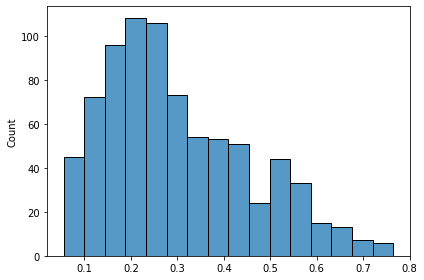

In [68]:
sns.histplot(predicted_scores)
plt.tight_layout()

In [69]:
evaluator = hlp.sklearn_eval.TwoClassEvaluator(
    actual_values=y_train,
    predicted_scores=predicted_scores,
    labels=labels_negative_positive,
    score_threshold=0.5
)

In [70]:
evaluator.all_metrics_df(return_style=True, round_by=3)

,Scores,Details
AUC,0.872,Area under the ROC curve (true pos. rate vs false pos. rate); ranges from 0.5 (purely random classifier) to 1.0 (perfect classifier)
True Positive Rate,0.365,"36.5% of positive instances were correctly identified.; i.e. 88 ""Defaulted"" labels were correctly identified out of 241 instances; a.k.a Sensitivity/Recall"
True Negative Rate,0.950,"95.0% of negative instances were correctly identified.; i.e. 531 ""Not Defaulted"" labels were correctly identified out of 559 instances"
False Positive Rate,0.050,"5.0% of negative instances were incorrectly identified as positive; i.e. 28 ""Not Defaulted"" labels were incorrectly identified as ""Defaulted"", out of 559 instances"
False Negative Rate,0.635,"63.5% of positive instances were incorrectly identified as negative; i.e. 153 ""Defaulted"" labels were incorrectly identified as ""Not Defaulted"", out of 241 instances"
Positive Predictive Value,0.759,"When the model claims an instance is positive, it is correct 75.9% of the time; i.e. out of the 116 times the model predicted ""Defaulted"", it was correct 88 times; a.k.a precision"
Negative Predictive Value,0.776,"When the model claims an instance is negative, it is correct 77.6% of the time; i.e. out of the 684 times the model predicted ""Not Defaulted"", it was correct 531 times"
F1 Score,0.493,"The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0."
Accuracy,0.774,77.4% of instances were correctly identified
Error Rate,0.226,22.6% of instances were incorrectly identified


In [71]:
del predicted_scores

## Test Set Evaluation

In [72]:
predicted_scores = fitted_pipeline.predict_proba(X_test)[:, 1]

In [73]:
predicted_scores[0:10]

array([0.3364269 , 0.3970507 , 0.5378342 , 0.29817235, 0.15741079,
       0.31766537, 0.13673802, 0.39016527, 0.13539012, 0.16803306],
      dtype=float32)

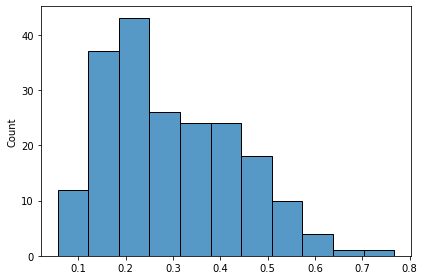

In [74]:
sns.histplot(predicted_scores)
plt.tight_layout()

In [75]:
y_test_cat = pd.Series(y_test).replace({1: 'Defaulted', 0: 'Not Defaulted'})
y_test_cat.head()

0        Defaulted
1    Not Defaulted
2    Not Defaulted
3    Not Defaulted
4    Not Defaulted
dtype: object

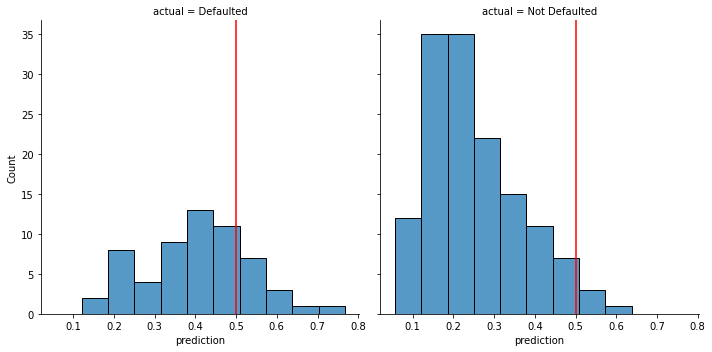

In [76]:
axes = sns.displot(
    pd.DataFrame({
        'prediction': predicted_scores,
        'actual': y_test_cat
    }),
    x='prediction',
    col='actual'
)
for axis in axes.axes.flat:
    axis.axvline(x=0.5, ymin=0, ymax=100, color='red')
plt.tight_layout()

In [77]:
del y_test_cat
del axes

In [78]:
evaluator = hlp.sklearn_eval.TwoClassEvaluator(
    actual_values=y_test,
    predicted_scores=predicted_scores,
    labels=labels_negative_positive,
    score_threshold=0.5
)

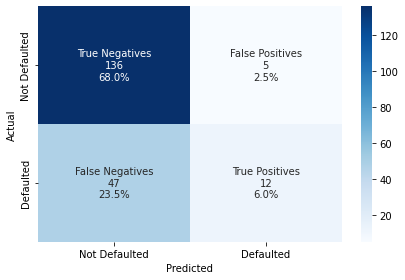

In [79]:
evaluator.plot_confusion_matrix()

In [80]:
evaluator.all_metrics_df(return_style=True, round_by=3)

,Scores,Details
AUC,0.811,Area under the ROC curve (true pos. rate vs false pos. rate); ranges from 0.5 (purely random classifier) to 1.0 (perfect classifier)
True Positive Rate,0.203,"20.3% of positive instances were correctly identified.; i.e. 12 ""Defaulted"" labels were correctly identified out of 59 instances; a.k.a Sensitivity/Recall"
True Negative Rate,0.965,"96.5% of negative instances were correctly identified.; i.e. 136 ""Not Defaulted"" labels were correctly identified out of 141 instances"
False Positive Rate,0.035,"3.5% of negative instances were incorrectly identified as positive; i.e. 5 ""Not Defaulted"" labels were incorrectly identified as ""Defaulted"", out of 141 instances"
False Negative Rate,0.797,"79.7% of positive instances were incorrectly identified as negative; i.e. 47 ""Defaulted"" labels were incorrectly identified as ""Not Defaulted"", out of 59 instances"
Positive Predictive Value,0.706,"When the model claims an instance is positive, it is correct 70.6% of the time; i.e. out of the 17 times the model predicted ""Defaulted"", it was correct 12 times; a.k.a precision"
Negative Predictive Value,0.743,"When the model claims an instance is negative, it is correct 74.3% of the time; i.e. out of the 183 times the model predicted ""Not Defaulted"", it was correct 136 times"
F1 Score,0.316,"The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0."
Accuracy,0.740,74.0% of instances were correctly identified
Error Rate,0.260,26.0% of instances were incorrectly identified


Compare results against scores if we predicted all `Good`

In [81]:
dummy_predicted_scores = np.array([0.99] * len(predicted_scores))

In [82]:
dummy_eval = hlp.sklearn_eval.TwoClassEvaluator(
    actual_values=y_test,
    predicted_scores=dummy_predicted_scores,
    labels=('Bad', 'Good'),
    score_threshold=0.5
)
dummy_eval.all_metrics_df(return_style=True, round_by=3)

,Scores,Details
AUC,0.500,Area under the ROC curve (true pos. rate vs false pos. rate); ranges from 0.5 (purely random classifier) to 1.0 (perfect classifier)
True Positive Rate,1.000,"100.0% of positive instances were correctly identified.; i.e. 59 ""Good"" labels were correctly identified out of 59 instances; a.k.a Sensitivity/Recall"
True Negative Rate,0.000,"0.0% of negative instances were correctly identified.; i.e. 0 ""Bad"" labels were correctly identified out of 141 instances"
False Positive Rate,1.000,"100.0% of negative instances were incorrectly identified as positive; i.e. 141 ""Bad"" labels were incorrectly identified as ""Good"", out of 141 instances"
False Negative Rate,0.000,"0.0% of positive instances were incorrectly identified as negative; i.e. 0 ""Good"" labels were incorrectly identified as ""Bad"", out of 59 instances"
Positive Predictive Value,0.295,"When the model claims an instance is positive, it is correct 29.5% of the time; i.e. out of the 200 times the model predicted ""Good"", it was correct 59 times; a.k.a precision"
Negative Predictive Value,0.000,"When the model claims an instance is negative, it is correct 0.0% of the time; i.e. out of the 0 times the model predicted ""Bad"", it was correct 0 times"
F1 Score,0.456,"The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0."
Accuracy,0.295,29.5% of instances were correctly identified
Error Rate,0.705,70.5% of instances were incorrectly identified


In [83]:
fig = evaluator.plot_auc_curve(return_plotly=True)
fig.show()

<Figure size 720x444.984 with 0 Axes>

In [91]:
fig = evaluator.plot_threshold_curves(score_threshold_range=(0.1, 0.6),
                                      return_plotly=True)
fig.show()

<Figure size 720x444.984 with 0 Axes>

In [92]:
fig = evaluator.plot_precision_recall_tradeoff(score_threshold_range=(0.1, 0.6),
                                               return_plotly=True)
fig.show()

<Figure size 720x444.984 with 0 Axes>

In [87]:
evaluator.calculate_lift_gain(return_style=True, include_all_info=True)

,# of Obs.,# of Pos. Events,Cumul. Pos. Events,Gain,Lift
Percentile,,,,,
5,10,8,8,0.14,2.71
10,10,6,14,0.24,2.37
15,10,6,20,0.34,2.26
20,10,8,28,0.47,2.37
25,10,5,33,0.56,2.24
30,10,4,37,0.63,2.09
35,10,3,40,0.68,1.94
40,10,5,45,0.76,1.91
45,10,2,47,0.80,1.77


In [88]:
del predicted_scores

# Feature Importance

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [89]:
from sklearn.inspection import permutation_importance
import time

estimator = full_pipeline

start_time = time.time()
result = permutation_importance(
    estimator, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

feature_names = X_train.columns.to_list()
forest_importances = pd.Series(result.importances_mean, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)

Elapsed time to compute the importances: 3.930 seconds


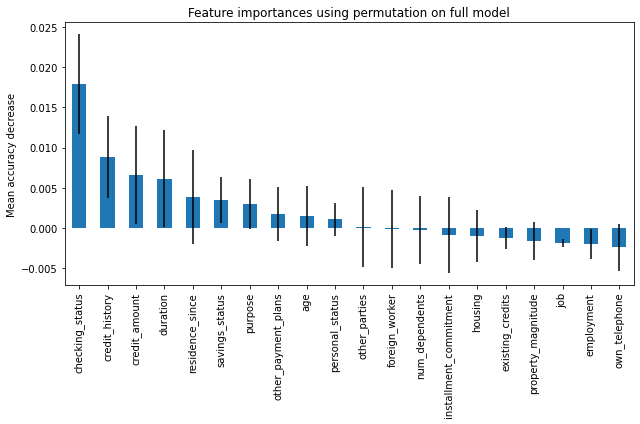

In [90]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.set_size_inches(9, 6)
fig.tight_layout()
plt.show()